In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

from scipy.spatial.distance import cdist 
from scipy.stats import ttest_ind

In [2]:
url_dmv_merged = 'https://raw.githubusercontent.com/kansjs/IBM_applied_capstone_share/master/DMV_food%202.9.20.csv'
# url_dmv_merged = 'https://raw.githubusercontent.com/kansjs/applied_ds_1.31.20/master/DMV_food%202.9.20.csv'
DMV_merged = pd.read_csv(url_dmv_merged)
DMV_merged.head()

,Venue,Latitude,Longitude,Venue Category,food_group
0,Trader Joe's,39.188164,-76.795467,Supermarket,Supermarket
1,Target,39.197493,-76.813360,Big Box Store,Supermarket
2,Giant,39.210065,-76.778580,Supermarket,Supermarket
3,Green Valley Marketplace,39.206965,-76.729124,Supermarket,Supermarket
4,Safeway,39.251080,-76.818721,Supermarket,Supermarket


In [3]:
DMV_merged.insert(loc=0, column='Id', value=np.arange(len(DMV_merged)))
DMV_merged.head()

,Id,Venue,Latitude,Longitude,Venue Category,food_group
0,0,Trader Joe's,39.188164,-76.795467,Supermarket,Supermarket
1,1,Target,39.197493,-76.813360,Big Box Store,Supermarket
2,2,Giant,39.210065,-76.778580,Supermarket,Supermarket
3,3,Green Valley Marketplace,39.206965,-76.729124,Supermarket,Supermarket
4,4,Safeway,39.251080,-76.818721,Supermarket,Supermarket


In [4]:
#min_lat = 38.69
#min_lon = -77.45
#lat_lon_ratio = 53.6/69
#Zones['Mean Latitude'] = (Zones['Mean Latitude'] - min_lat) * lat_lon_ratio
#Zones['Mean Longitude'] = Zones['Mean Longitude'] - min_lon

In [5]:
# Adjustment of latitude and longitude to reflect longitude/latitude ratio in DC area
min_lat = 38.69
min_lon = -77.45
lon_lat_ratio = 53.6/69

DMV_sites = DMV_merged.loc[:,['Id', 'Latitude', 'Longitude']]
DMV_sites_B = DMV_sites.copy()
DMV_sites_B['Adj_Latitude'] = DMV_sites_B['Latitude'] - min_lat 
DMV_sites_B['Adj_Longitude'] = (DMV_sites_B['Longitude'] - min_lon) * lon_lat_ratio
DMV_sites_B.head()

,Id,Latitude,Longitude,Adj_Latitude,Adj_Longitude
0,0,39.188164,-76.795467,0.498164,0.508449
1,1,39.197493,-76.813360,0.507493,0.494549
2,2,39.210065,-76.778580,0.520065,0.521567
3,3,39.206965,-76.729124,0.516965,0.559985
4,4,39.251080,-76.818721,0.561080,0.490385


In [6]:
kclusters = 50
#DMV_sites_B = DMV_sites.copy()
DMV_sites_B.drop(['Id', 'Latitude', 'Longitude'], axis=1, inplace=True)
#DMV_sites_B.drop(['Id', 'Latitude', 'Longitude'], axis=1, inplace=True)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(DMV_sites_B)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:30]

array([13, 43, 20, 40, 20, 20, 43, 20, 45, 43, 43, 45, 41, 41, 41, 41, 41,
       43, 13, 34, 34,  1, 34, 24, 43, 24, 24,  1, 43, 39], dtype=int32)

In [7]:
DMV_sites.insert(0, 'Zone', kmeans.labels_)
DMV_sites.head()

,Zone,Id,Latitude,Longitude
0,13,0,39.188164,-76.795467
1,43,1,39.197493,-76.813360
2,20,2,39.210065,-76.778580
3,40,3,39.206965,-76.729124
4,20,4,39.251080,-76.818721


In [8]:
DMV_sites2 = DMV_sites.copy()
Lat_avg = DMV_sites2.groupby('Zone', as_index=False)['Latitude'].mean()
Lat_avg.rename(columns={'Latitude':'Mean Latitude'}, inplace=True)

Lat_avg.head(10)

,Zone,Mean Latitude
0,0,38.719122
1,1,39.095215
2,2,38.972255
3,3,38.892374
4,4,39.129156
5,5,38.881759
6,6,38.982088
7,7,38.907150
8,8,38.851845
9,9,38.871798


In [9]:
Lon_avg = DMV_sites2.groupby('Zone', as_index=False)['Longitude'].mean()
Lon_avg.rename(columns={'Longitude':'Mean Longitude'}, inplace=True)
Lon_avg.head(10)

,Zone,Mean Longitude
0,0,-77.132254
1,1,-76.842329
2,2,-77.006462
3,3,-77.433941
4,4,-77.281369
5,5,-77.103854
6,6,-76.942892
7,7,-77.019360
8,8,-77.306202
9,9,-76.923826


In [10]:
# create map

center_lat = 38.91084
center_lon = -77.01780

map_clusters = folium.Map(location=[center_lat, center_lon], zoom_start=11, tiles='Stamen Toner')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(DMV_sites['Latitude'], DMV_sites['Longitude'], DMV_sites['Zone']):
#    label = '{}, {}, {}'.format(cluster, lat, lon)
#    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
#        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [11]:
DMV_combined = pd.concat([DMV_merged, DMV_sites.iloc[:, 0]], axis=1)
# DMV_combined = pd.concat([DMV_merged, DMV_sites_B.iloc[:, 0]], axis=1)
DMV_combined.head(10)

,Id,Venue,Latitude,Longitude,Venue Category,food_group,Zone
0,0,Trader Joe's,39.188164,-76.795467,Supermarket,Supermarket,13
1,1,Target,39.197493,-76.813360,Big Box Store,Supermarket,43
2,2,Giant,39.210065,-76.778580,Supermarket,Supermarket,20
3,3,Green Valley Marketplace,39.206965,-76.729124,Supermarket,Supermarket,40
4,4,Safeway,39.251080,-76.818721,Supermarket,Supermarket,20
5,5,Giant Food #300,39.227792,-76.816907,Supermarket,Supermarket,20
6,6,Walmart,39.195811,-76.819498,Supermarket,Supermarket,43
7,7,Giant,39.243356,-76.842883,Supermarket,Supermarket,20
8,8,Giant,39.211501,-76.935549,Supermarket,Supermarket,45
9,9,Giant Food,39.194537,-76.883963,Supermarket,Supermarket,43


In [12]:
DMV_combined.shape

(2464, 7)

In [13]:
DMV_combined.groupby('Zone').count()
# DMV_combined.groupby('Cluster Labels').count()
#toronto_venues_top.groupby('Neighbourhood').count()

,Id,Venue,Latitude,Longitude,Venue Category,food_group
Zone,,,,,,
0,30,30,30,30,30,30
1,67,67,67,67,67,67
2,106,106,106,106,106,106
3,39,39,39,39,39,39
4,25,25,25,25,25,25
5,95,95,95,95,95,95
6,67,67,67,67,67,67
7,153,153,153,153,153,153
8,58,58,58,58,58,58


In [14]:
DMV_onehot = pd.get_dummies(DMV_combined[['food_group']], prefix="", prefix_sep="")
DMV_onehot.insert(0, 'Zone', DMV_combined['Zone'])
DMV_onehot.head(25)

,Zone,Convenience,Dollar,Fast Food,Supermarket
0,13,0,0,0,1
1,43,0,0,0,1
2,20,0,0,0,1
3,40,0,0,0,1
4,20,0,0,0,1
5,20,0,0,0,1
6,43,0,0,0,1
7,20,0,0,0,1
8,45,0,0,0,1
9,43,0,0,0,1


In [15]:
DMV_grouped = DMV_onehot.groupby('Zone').mean().reset_index()
#DMV_grouped = DMV_onehot.groupby('Cluster Labels').mean().reset_index()
DMV_grouped

,Zone,Convenience,Dollar,Fast Food,Supermarket
0,0,0.433333,0.066667,0.466667,0.033333
1,1,0.402985,0.074627,0.388060,0.134328
2,2,0.490566,0.047170,0.367925,0.094340
3,3,0.205128,0.076923,0.564103,0.153846
4,4,0.280000,0.080000,0.480000,0.160000
5,5,0.442105,0.000000,0.452632,0.105263
6,6,0.432836,0.044776,0.432836,0.089552
7,7,0.496732,0.026144,0.313725,0.163399
8,8,0.344828,0.017241,0.500000,0.137931
9,9,0.507463,0.119403,0.313433,0.059701


In [16]:
### DMV_combined_B = pd.concat([DMV_merged, DMV_sites.iloc[:, 0]], axis=1)

In [17]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [18]:
num_top_venues = 4

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zone']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Zone'] = DMV_grouped['Zone']

for ind in np.arange(DMV_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(DMV_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Zone,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,0,Fast Food,Convenience,Dollar,Supermarket
1,1,Convenience,Fast Food,Supermarket,Dollar
2,2,Convenience,Fast Food,Supermarket,Dollar
3,3,Fast Food,Convenience,Supermarket,Dollar
4,4,Fast Food,Convenience,Supermarket,Dollar
5,5,Fast Food,Convenience,Supermarket,Dollar
6,6,Fast Food,Convenience,Supermarket,Dollar
7,7,Convenience,Fast Food,Supermarket,Dollar
8,8,Fast Food,Convenience,Supermarket,Dollar
9,9,Convenience,Fast Food,Dollar,Supermarket


In [19]:
## Identify number of clusters
## Shout-out to 'https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/'

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 

DMV_grouped_clustering = DMV_grouped.drop('Zone', 1)

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(DMV_grouped_clustering) 
    kmeanModel.fit(DMV_grouped_clustering)     
      
    distortions.append(sum(np.min(cdist(DMV_grouped_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / DMV_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(DMV_grouped_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / DMV_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

In [20]:
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val))

1 : 0.1319123802309273
2 : 0.08859387552519368
3 : 0.07690349427224547
4 : 0.06636205266735869
5 : 0.06127894681334707
6 : 0.05580190361742068
7 : 0.05216671196325222
8 : 0.0470009876479919
9 : 0.0447734531979476


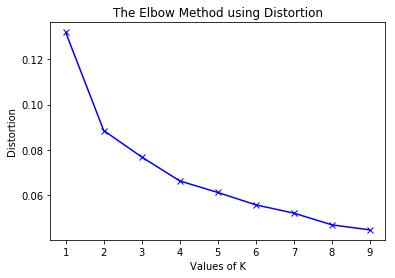

In [21]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

In [22]:
for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val)) 

1 : 1.0421189701990374
2 : 0.4449773909444467
3 : 0.334784790706788
4 : 0.2533702940407898
5 : 0.21580334518227262
6 : 0.18405533910498167
7 : 0.15649020770574273
8 : 0.12847959816342763
9 : 0.11767597640694966


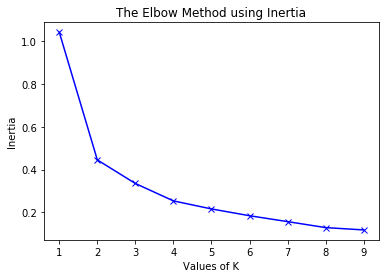

In [23]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

In [24]:
# set number of clusters
kclusters = 4

DMV_grouped_clustering = DMV_grouped.drop('Zone', 1)
#DMV_grouped_clustering = DMV_grouped.drop('Cluster Labels', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(DMV_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 2, 3, 1, 0, 0, 2, 1, 2], dtype=int32)

In [25]:
DMV_grouped.insert(0, 'Cluster Labels', kmeans.labels_)
DMV_grouped.head()

,Cluster Labels,Zone,Convenience,Dollar,Fast Food,Supermarket
0,0,0,0.433333,0.066667,0.466667,0.033333
1,0,1,0.402985,0.074627,0.388060,0.134328
2,2,2,0.490566,0.047170,0.367925,0.094340
3,3,3,0.205128,0.076923,0.564103,0.153846
4,1,4,0.280000,0.080000,0.480000,0.160000


In [26]:
DMV_grouped = pd.concat([DMV_grouped, Lat_avg.iloc[:, 1]], axis=1)
DMV_grouped = pd.concat([DMV_grouped, Lon_avg.iloc[:, 1]], axis=1)                         
DMV_grouped.head()                       

#DMV_combined = pd.concat([DMV_merged, DMV_sites.iloc[:, 0]], axis=1)

,Cluster Labels,Zone,Convenience,Dollar,Fast Food,Supermarket,Mean Latitude,Mean Longitude
0,0,0,0.433333,0.066667,0.466667,0.033333,38.719122,-77.132254
1,0,1,0.402985,0.074627,0.388060,0.134328,39.095215,-76.842329
2,2,2,0.490566,0.047170,0.367925,0.094340,38.972255,-77.006462
3,3,3,0.205128,0.076923,0.564103,0.153846,38.892374,-77.433941
4,1,4,0.280000,0.080000,0.480000,0.160000,39.129156,-77.281369


In [27]:
# create map
map_clusters2 = folium.Map(location=[center_lat, center_lon], zoom_start=11, tiles='Stamen Toner')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(DMV_grouped['Mean Latitude'], DMV_grouped['Mean Longitude'], DMV_grouped['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
#    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
#        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2

### Cluster 0

In [28]:
mean_cl = pd.DataFrame(DMV_grouped[DMV_grouped['Cluster Labels'] == 0].mean())
std_cl = pd.DataFrame(DMV_grouped[DMV_grouped['Cluster Labels'] == 0].std())
joint_cl = pd.concat([mean_cl, std_cl], axis=1)
joint_cl.columns = ['mean', 'std'] 
joint_cl = joint_cl.iloc[2:6, : ]
joint_cl

,mean,std
Convenience,0.425053,0.030089
Dollar,0.053939,0.043282
Fast Food,0.441400,0.029301
Supermarket,0.079608,0.028245


In [29]:
DMV_grouped.loc[DMV_grouped['Cluster Labels'] == 0, DMV_grouped.columns[2:6]]

,Convenience,Dollar,Fast Food,Supermarket
0,0.433333,0.066667,0.466667,0.033333
1,0.402985,0.074627,0.388060,0.134328
5,0.442105,0.000000,0.452632,0.105263
6,0.432836,0.044776,0.432836,0.089552
12,0.414634,0.097561,0.390244,0.097561
13,0.400000,0.066667,0.466667,0.066667
14,0.388060,0.059701,0.462687,0.089552
23,0.432432,0.081081,0.432432,0.054054
26,0.388889,0.111111,0.444444,0.055556
27,0.487179,0.000000,0.435897,0.076923


### Cluster 1

In [30]:
mean_cl = pd.DataFrame(DMV_grouped[DMV_grouped['Cluster Labels'] == 1].mean())
std_cl = pd.DataFrame(DMV_grouped[DMV_grouped['Cluster Labels'] == 1].std())
joint_cl = pd.concat([mean_cl, std_cl], axis=1)
joint_cl.columns = ['mean', 'std'] 
joint_cl = joint_cl.iloc[2:6, : ]
joint_cl

,mean,std
Convenience,0.308930,0.034391
Dollar,0.044334,0.037637
Fast Food,0.502521,0.030445
Supermarket,0.144214,0.038949


In [31]:
DMV_grouped.loc[DMV_grouped['Cluster Labels'] == 1, DMV_grouped.columns[2:6]]

,Convenience,Dollar,Fast Food,Supermarket
4,0.280000,0.080000,0.480000,0.160000
8,0.344828,0.017241,0.500000,0.137931
11,0.287879,0.060606,0.515152,0.136364
17,0.340000,0.100000,0.500000,0.060000
19,0.313433,0.029851,0.552239,0.104478
21,0.250000,0.113636,0.500000,0.136364
22,0.268293,0.024390,0.487805,0.219512
24,0.259259,0.111111,0.518519,0.111111
28,0.343750,0.062500,0.500000,0.093750
31,0.355556,0.022222,0.444444,0.177778


### Cluster 2

In [32]:
mean_cl = pd.DataFrame(DMV_grouped[DMV_grouped['Cluster Labels'] == 2].mean())
std_cl = pd.DataFrame(DMV_grouped[DMV_grouped['Cluster Labels'] == 2].std())
joint_cl = pd.concat([mean_cl, std_cl], axis=1)
joint_cl.columns = ['mean', 'std'] 
joint_cl = joint_cl.iloc[2:6, : ]
joint_cl

,mean,std
Convenience,0.485013,0.040699
Dollar,0.040588,0.040534
Fast Food,0.350111,0.030351
Supermarket,0.124289,0.049060


In [33]:
DMV_grouped.loc[DMV_grouped['Cluster Labels'] == 2, DMV_grouped.columns[2:6]]

,Convenience,Dollar,Fast Food,Supermarket
2,0.490566,0.047170,0.367925,0.094340
7,0.496732,0.026144,0.313725,0.163399
9,0.507463,0.119403,0.313433,0.059701
16,0.462500,0.000000,0.387500,0.150000
18,0.468750,0.093750,0.312500,0.125000
20,0.482759,0.000000,0.379310,0.137931
25,0.510638,0.021277,0.361702,0.106383
29,0.377778,0.044444,0.355556,0.222222
30,0.500000,0.000000,0.400000,0.100000
32,0.538462,0.092308,0.323077,0.046154


### Cluster 3

In [34]:
mean_cl = pd.DataFrame(DMV_grouped[DMV_grouped['Cluster Labels'] == 3].mean())
std_cl = pd.DataFrame(DMV_grouped[DMV_grouped['Cluster Labels'] == 3].std())
joint_cl = pd.concat([mean_cl, std_cl], axis=1)
joint_cl.columns = ['mean', 'std'] 
joint_cl = joint_cl.iloc[2:6, : ]
joint_cl

,mean,std
Convenience,0.196687,0.026455
Dollar,0.049443,0.041526
Fast Food,0.601837,0.042933
Supermarket,0.152033,0.052780


In [35]:
DMV_grouped.loc[DMV_grouped['Cluster Labels'] == 3, DMV_grouped.columns[2:6]]

,Convenience,Dollar,Fast Food,Supermarket
3,0.205128,0.076923,0.564103,0.153846
10,0.232558,0.116279,0.558140,0.093023
15,0.200000,0.000000,0.640000,0.160000
33,0.150943,0.037736,0.566038,0.245283
34,0.200000,0.044444,0.644444,0.111111
43,0.191489,0.021277,0.638298,0.148936


In [36]:
supermarket_0 = (DMV_grouped[DMV_grouped['Cluster Labels'] == 0])['Supermarket']
supermarket_1 = (DMV_grouped[DMV_grouped['Cluster Labels'] == 1])['Supermarket']
supermarket_2 = (DMV_grouped[DMV_grouped['Cluster Labels'] == 2])['Supermarket']
supermarket_3 = (DMV_grouped[DMV_grouped['Cluster Labels'] == 3])['Supermarket']

print(supermarket_0, supermarket_1, supermarket_2, supermarket_3) 


0     0.033333
1     0.134328
5     0.105263
6     0.089552
12    0.097561
13    0.066667
14    0.089552
23    0.054054
26    0.055556
27    0.076923
37    0.034483
38    0.113636
40    0.083333
42    0.090909
47    0.068966
Name: Supermarket, dtype: float64 4     0.160000
8     0.137931
11    0.136364
17    0.060000
19    0.104478
21    0.136364
22    0.219512
24    0.111111
28    0.093750
31    0.177778
35    0.188679
36    0.170213
39    0.178571
41    0.156863
44    0.118644
45    0.153846
48    0.147541
Name: Supermarket, dtype: float64 2     0.094340
7     0.163399
9     0.059701
16    0.150000
18    0.125000
20    0.137931
25    0.106383
29    0.222222
30    0.100000
32    0.046154
46    0.113924
49    0.172414
Name: Supermarket, dtype: float64 3     0.153846
10    0.093023
15    0.160000
33    0.245283
34    0.111111
43    0.148936
Name: Supermarket, dtype: float64


In [37]:
# Students t-test for all combinations 
# see https://machinelearningmastery.com/parametric-statistical-significance-tests-in-python/
stat, p = ttest_ind(supermarket_0, supermarket_1)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=-5.306, p=0.000


In [38]:
stat, p = ttest_ind(supermarket_0, supermarket_2)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=-2.973, p=0.006


In [39]:
stat, p = ttest_ind(supermarket_0, supermarket_3)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=-4.125, p=0.001


In [40]:
stat, p = ttest_ind(supermarket_1, supermarket_2)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=1.219, p=0.233


In [41]:
stat, p = ttest_ind(supermarket_1, supermarket_3)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=-0.386, p=0.703


In [42]:
stat, p = ttest_ind(supermarket_2, supermarket_3)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=-1.104, p=0.286


In [43]:
convenience_0 = (DMV_grouped[DMV_grouped['Cluster Labels'] == 0])['Convenience']
convenience_1 = (DMV_grouped[DMV_grouped['Cluster Labels'] == 1])['Convenience']
convenience_2 = (DMV_grouped[DMV_grouped['Cluster Labels'] == 2])['Convenience']
convenience_3 = (DMV_grouped[DMV_grouped['Cluster Labels'] == 3])['Convenience']

print(convenience_0, convenience_1, convenience_2, convenience_3) 

0     0.433333
1     0.402985
5     0.442105
6     0.432836
12    0.414634
13    0.400000
14    0.388060
23    0.432432
26    0.388889
27    0.487179
37    0.448276
38    0.454545
40    0.416667
42    0.454545
47    0.379310
Name: Convenience, dtype: float64 4     0.280000
8     0.344828
11    0.287879
17    0.340000
19    0.313433
21    0.250000
22    0.268293
24    0.259259
28    0.343750
31    0.355556
35    0.339623
36    0.297872
39    0.285714
41    0.294118
44    0.355932
45    0.307692
48    0.327869
Name: Convenience, dtype: float64 2     0.490566
7     0.496732
9     0.507463
16    0.462500
18    0.468750
20    0.482759
25    0.510638
29    0.377778
30    0.500000
32    0.538462
46    0.518987
49    0.465517
Name: Convenience, dtype: float64 3     0.205128
10    0.232558
15    0.200000
33    0.150943
34    0.200000
43    0.191489
Name: Convenience, dtype: float64


In [44]:
stat, p = ttest_ind(convenience_0, convenience_1)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=10.100, p=0.000


In [45]:
stat, p = ttest_ind(convenience_0, convenience_2)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=-4.404, p=0.000


In [46]:
stat, p = ttest_ind(convenience_0, convenience_3)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=16.203, p=0.000


In [47]:
stat, p = ttest_ind(convenience_1, convenience_2)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=-12.591, p=0.000


In [48]:
stat, p = ttest_ind(convenience_1, convenience_3)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=7.234, p=0.000


In [49]:
stat, p = ttest_ind(convenience_2, convenience_3)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=15.651, p=0.000


In [50]:
fast_food_0 = (DMV_grouped[DMV_grouped['Cluster Labels'] == 0])['Fast Food']
fast_food_1 = (DMV_grouped[DMV_grouped['Cluster Labels'] == 1])['Fast Food']
fast_food_2 = (DMV_grouped[DMV_grouped['Cluster Labels'] == 2])['Fast Food']
fast_food_3 = (DMV_grouped[DMV_grouped['Cluster Labels'] == 3])['Fast Food']

print(fast_food_0, fast_food_1, fast_food_2, fast_food_3) 

0     0.466667
1     0.388060
5     0.452632
6     0.432836
12    0.390244
13    0.466667
14    0.462687
23    0.432432
26    0.444444
27    0.435897
37    0.413793
38    0.431818
40    0.500000
42    0.454545
47    0.448276
Name: Fast Food, dtype: float64 4     0.480000
8     0.500000
11    0.515152
17    0.500000
19    0.552239
21    0.500000
22    0.487805
24    0.518519
28    0.500000
31    0.444444
35    0.433962
36    0.510638
39    0.535714
41    0.509804
44    0.491525
45    0.538462
48    0.524590
Name: Fast Food, dtype: float64 2     0.367925
7     0.313725
9     0.313433
16    0.387500
18    0.312500
20    0.379310
25    0.361702
29    0.355556
30    0.400000
32    0.323077
46    0.341772
49    0.344828
Name: Fast Food, dtype: float64 3     0.564103
10    0.558140
15    0.640000
33    0.566038
34    0.644444
43    0.638298
Name: Fast Food, dtype: float64


In [51]:
stat, p = ttest_ind(fast_food_0, fast_food_1)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=-5.767, p=0.000


In [52]:
stat, p = ttest_ind(fast_food_0, fast_food_2)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=7.918, p=0.000


In [53]:
stat, p = ttest_ind(fast_food_0, fast_food_3)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=-9.935, p=0.000


In [54]:
stat, p = ttest_ind(fast_food_1, fast_food_2)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=13.294, p=0.000


In [55]:
stat, p = ttest_ind(fast_food_1, fast_food_3)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=-6.181, p=0.000


In [56]:
stat, p = ttest_ind(fast_food_2, fast_food_3)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=-14.477, p=0.000


In [57]:
dollar_0 = (DMV_grouped[DMV_grouped['Cluster Labels'] == 0])['Dollar']
dollar_1 = (DMV_grouped[DMV_grouped['Cluster Labels'] == 1])['Dollar']
dollar_2 = (DMV_grouped[DMV_grouped['Cluster Labels'] == 2])['Dollar']
dollar_3 = (DMV_grouped[DMV_grouped['Cluster Labels'] == 3])['Dollar']

print(dollar_0, dollar_1, dollar_2, dollar_3) 

0     0.066667
1     0.074627
5     0.000000
6     0.044776
12    0.097561
13    0.066667
14    0.059701
23    0.081081
26    0.111111
27    0.000000
37    0.103448
38    0.000000
40    0.000000
42    0.000000
47    0.103448
Name: Dollar, dtype: float64 4     0.080000
8     0.017241
11    0.060606
17    0.100000
19    0.029851
21    0.113636
22    0.024390
24    0.111111
28    0.062500
31    0.022222
35    0.037736
36    0.021277
39    0.000000
41    0.039216
44    0.033898
45    0.000000
48    0.000000
Name: Dollar, dtype: float64 2     0.047170
7     0.026144
9     0.119403
16    0.000000
18    0.093750
20    0.000000
25    0.021277
29    0.044444
30    0.000000
32    0.092308
46    0.025316
49    0.017241
Name: Dollar, dtype: float64 3     0.076923
10    0.116279
15    0.000000
33    0.037736
34    0.044444
43    0.021277
Name: Dollar, dtype: float64


In [58]:
stat, p = ttest_ind(dollar_0, dollar_1)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.672, p=0.507


In [59]:
stat, p = ttest_ind(dollar_0, dollar_2)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.819, p=0.421


In [60]:
stat, p = ttest_ind(dollar_0, dollar_3)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.217, p=0.830


In [61]:
stat, p = ttest_ind(dollar_1, dollar_2)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.256, p=0.800


In [62]:
stat, p = ttest_ind(dollar_1, dollar_3)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=-0.279, p=0.783


In [63]:
stat, p = ttest_ind(dollar_2, dollar_3)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=-0.434, p=0.670
